In [1]:
import os
import torch
torch.manual_seed(int(1e9+7e7+17+3))
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
# %matplotlib widget
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from ilt_data import PNGFolderDataset, tensor_to_image
from ilt_model import DualLithoZernikeRegressor
# torch.multiprocessing.set_start_method('spawn') # extremely slow
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, message='Torchinductor does not support code generation for complex operators. Performance may be worse than eager.')

In [ ]:
# from PIL import Image, ImageDraw

# # Параметры
# size = 2048
# radius = 80  # 70px после масштабирования в 4 раза (70*4=280px диаметр)
# step = 320    # Шаг 320px → после масштабирования 80px
# margin = 200  # Отступ 160px → после масштабирования 40px

# # Создаём бинарное изображение (0 или 255)
# image = Image.new("L", (size, size), 0)  # 'L' — grayscale, 0=чёрный
# draw = ImageDraw.Draw(image)

# # Рисуем кружки
# for y in range(margin, size, step):
#     for x in range(margin, size, step):
#         draw.ellipse([x-radius, y-radius, x+radius, y+radius], fill=255)

# image.save("../../grid_mask.png", compress_level=0)  # Без сжатия

In [3]:
DATASET_ROOT = os.path.join('..', 'dataset', 'train_layouts')
workers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20, split=0.8, workers=1, load_all_to_ram=False):
    dataset = PNGFolderDataset(root, N_zernike=num_zernike, image_size=1024, aberr_max=3.,
                               device=dataset_device, load_all_to_ram=load_all_to_ram, num_threads=workers)
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    return train_loader, val_loader, dataset

## Load

Aberrations: Z=[-4.9512852e-03 -1.5235330e+00  6.8338931e-02 -2.0413927e-03
  4.0928188e-01  1.8809472e-09 -1.2622718e-02 -1.0122241e+00
 -6.1333994e-04  8.7409794e-02 -8.3820206e-01  7.2876946e-04
  3.3703260e-02 -2.1457700e-01  1.2451756e-01]


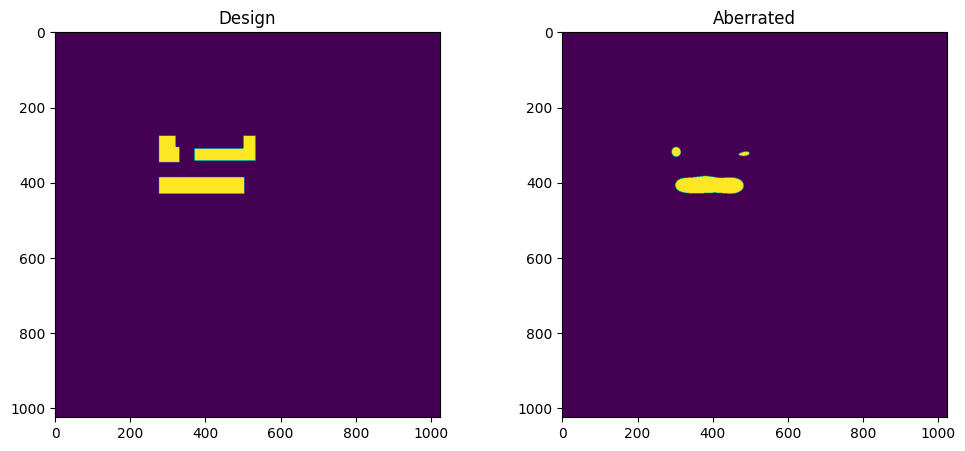

In [5]:
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=1, num_zernike=15, workers=0)
a = next(iter(train_loader))
i = 0

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][0]))
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][i][1]))
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1][i].cpu().numpy()}")
plt.show()

In [6]:
# -------- 4. Training --------
"mobilenet_v3_small" # 1.5 M / 1.06 m
"mobilenet_v3_large" # 4.2 M / 1.13 m
"efficientnet_b0"    # 4.0 M / 1.45 m
"efficientnet_b2"    # 7.7 M
train_loader, val_loader, dataset = make_dataloaders(DATASET_ROOT, batch_size=8, num_zernike=15, workers=0, load_all_to_ram=False)
warmup_epochs = 1
accumulate_grad_batches = 8
warmup_steps = warmup_epochs * len(train_loader) / accumulate_grad_batches
# model = DualLithoZernikeRegressor("mobilenet_v3_small", num_zernike=15, lr=1e-3, warmup_steps=warmup_steps)
model = DualLithoZernikeRegressor.load_from_checkpoint(
"lightning_logs/Dual Mobilenet_v3 1024 v4/checkpoints/best-model.ckpt")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-model'
)
logger = TensorBoardLogger(".", name="lightning_logs", version="Dual Mobilenet_v3 1024 v4 small")

trainer = Trainer(max_epochs=100, accelerator="auto", callbacks=[checkpoint_callback],
                  accumulate_grad_batches = accumulate_grad_batches, #gradient_clip_val=1.,
                  logger=logger,
                  precision="16-mixed",
                  # devices=[1],
          )
# trainer.fit(model, train_loader, val_loader)#, ckpt_path="lightning_logs/Dual Mobilenet_v3 1024 v4 small/checkpoints/best-model.ckpt")

/root/anaconda3/envs/SK/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.0
/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/SK/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using

In [7]:
# #### CLEAR CACHE #####
# model.cpu()
# from gc import collect
# imgs, z_true = None, None
# litho_imgs, aberr_imgs, restored_imgs = None, None, None
# z_preds = None
# batch = None
# collect()
# torch.cuda.empty_cache()
# collect()

## Inference

In [22]:
from torchvision import transforms
import lithosim_cuda as litho
from fnmatch import fnmatch
from lt_simulator import LTSimulator
import numpy as np

class SignleSampler:
    def __init__(self, root, N_zernike: int = 15, transform=None, amp=1.):
        self.N_zernike = N_zernike
        self.transform = transform
        self.mask_path = None
        # self.litho_path = None
        # self.amp = amp * np.array([5,5,5, 5.2,2.2,5.5, 10,10,10., 12,1.45,2.95,2.95,17,60])
        self.sim = LTSimulator(device=device)

        self.filenames = []
        for path, subdirs, files in os.walk(root):
            for name in files:
                ext = '.png'
                if fnmatch(name, f'*{ext}'):
                    if name == 'grid'+ext:
                        self.litho_path = os.path.join(path, name)
                    elif name == 'grid_mask'+ext:
                        self.mask_path = os.path.join(path, name)
                    else:
                        self.filenames.append(os.path.join(path, name))
        self.filenames.sort()

    def __len__(self):
        # return len(self.filenames)
        return 10#self.N_zernike
    
    def __call__(self, idx):
        # img_path = self.filenames[idx]

        zernike_coeffs = torch.zeros(self.N_zernike, device=device)
        zernike_coeffs += torch.tensor([
            [0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
            [1.0, 0.9, -0.2, 0.8, 1.0, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.7, 0.7, 2.0, 0.9, 0.0, 0.0, 1.2, 1.1, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        ],device=device)[idx]
        # if idx != -1:
        #     zernike_coeffs[idx] += self.amp[idx]

        design_img = litho.load_image(self.mask_path).to(device)
        # litho_img = litho.load_image(self.litho_path).to(design_img.device)
        litho_img = self.sim.run_lithosim(design_img)[0]
        # aberrated_img = litho.load_image(img_path).to(design_img.device)
        aberrated_img = self.sim.run_lithosim(design_img, zernike_coeffs=zernike_coeffs)[0]
        if self.transform is not None:
            design_img = self.transform(design_img)
            litho_img = self.transform(litho_img)
            aberrated_img = self.transform(aberrated_img)

        # img_name = '.'.join(os.path.basename(img_path).split('.')[:-1])
        # zernike_coeffs = torch.zeros(self.N_zernike, device=litho_img.device)
        # idx, coef = int(img_name.split('_')[-2]), float(img_name.split('_')[-1])
        # if idx < self.N_zernike:
        #     zernike_coeffs[idx] += coef

        imgs = torch.cat([design_img, litho_img, aberrated_img], dim=0) # 3 x H x W
            
        return imgs, zernike_coeffs
    
    def intensity_tensor_to_image(self, intensity):
        return tensor_to_image(litho.mask_threshold(intensity, self.sim.config.threshold))

image_size=1024
transform = transforms.Compose([
            torch.compile(transforms.Resize((image_size, image_size))),
        ])
dataset = SignleSampler('../../model/grid_data/', transform=transform)

Aberrations: Z=[0.  0.7 0.7 2.  0.9 0.  0.  1.2 1.1 5.  0.  0.  0.  0.  0. ]


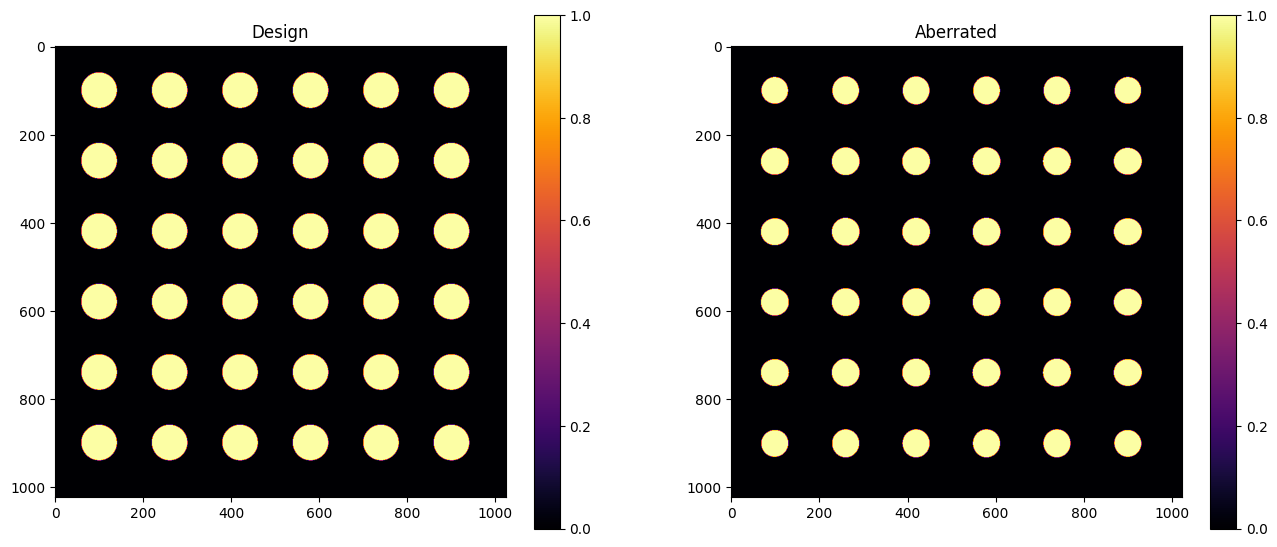

In [23]:
a = dataset(-1)

fig = plt.figure(figsize=(16,5*4/3))
ax = plt.subplot(1,2,1)
plt.imshow(dataset.intensity_tensor_to_image(a[0][0]), cmap='inferno')
plt.colorbar()
ax.set_title("Design")
ax = plt.subplot(1,2,2)
plt.imshow(dataset.intensity_tensor_to_image(a[0][1]), cmap='inferno')
plt.colorbar()
ax.set_title("Aberrated")
print(f"Aberrations: Z={a[1].cpu().numpy()}")
plt.show()

In [24]:
b = [dataset(i) for i in range(len(dataset))]
imgs = torch.stack([sample[0] for sample in b]).to(device)
z_true = torch.stack([sample[1] for sample in b]).to(device)

In [25]:
litho_aberr_imgs = imgs[:, 1:]
with torch.no_grad():
    z_preds, z_rev_preds = model(litho_aberr_imgs)

    design_imgs, litho_imgs, aberr_imgs = torch.split(imgs, 1, dim=1) # [B, 3, H, W] -> [B, (1, 1, 1), H, W]

    modelled_imgs = model.sim.run_lithosim(design_imgs, zernike_coeffs=z_preds)
    reconstructed_imgs = model.sim.run_lithosim(aberr_imgs, zernike_coeffs=z_rev_preds)

/root/anaconda3/envs/SK/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0724 13:29:18.821000 2112 site-packages/torch/_inductor/utils.py:1250] [1/1] Not enough SMs to use max_autotune_gemm mode


In [41]:
def str_canonize(t: torch.Tensor):
    return ', '.join(str(t.cpu().numpy()).replace('  ',' ').split(' '))

Aberrations: Z=[0.  1.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] Preds=[ 0.0079388   2.3178926  -0.18844742 -0.32039547  0.25353107 -0.2514053
  0.03803767 -0.29570416  0.24692345 -0.2693813  -0.00972669 -0.35861015
 -0.21135977  0.11146637 -0.04961045] Inverse=[ 3.419296   -1.058645   -0.02773839  0.7191447  -0.03245553 -0.7826214
  0.6033705   1.0425235  -0.32576075 -0.14757763 -0.22822441 -0.35128164
 -0.9777974   1.1600113  -1.4579949 ]


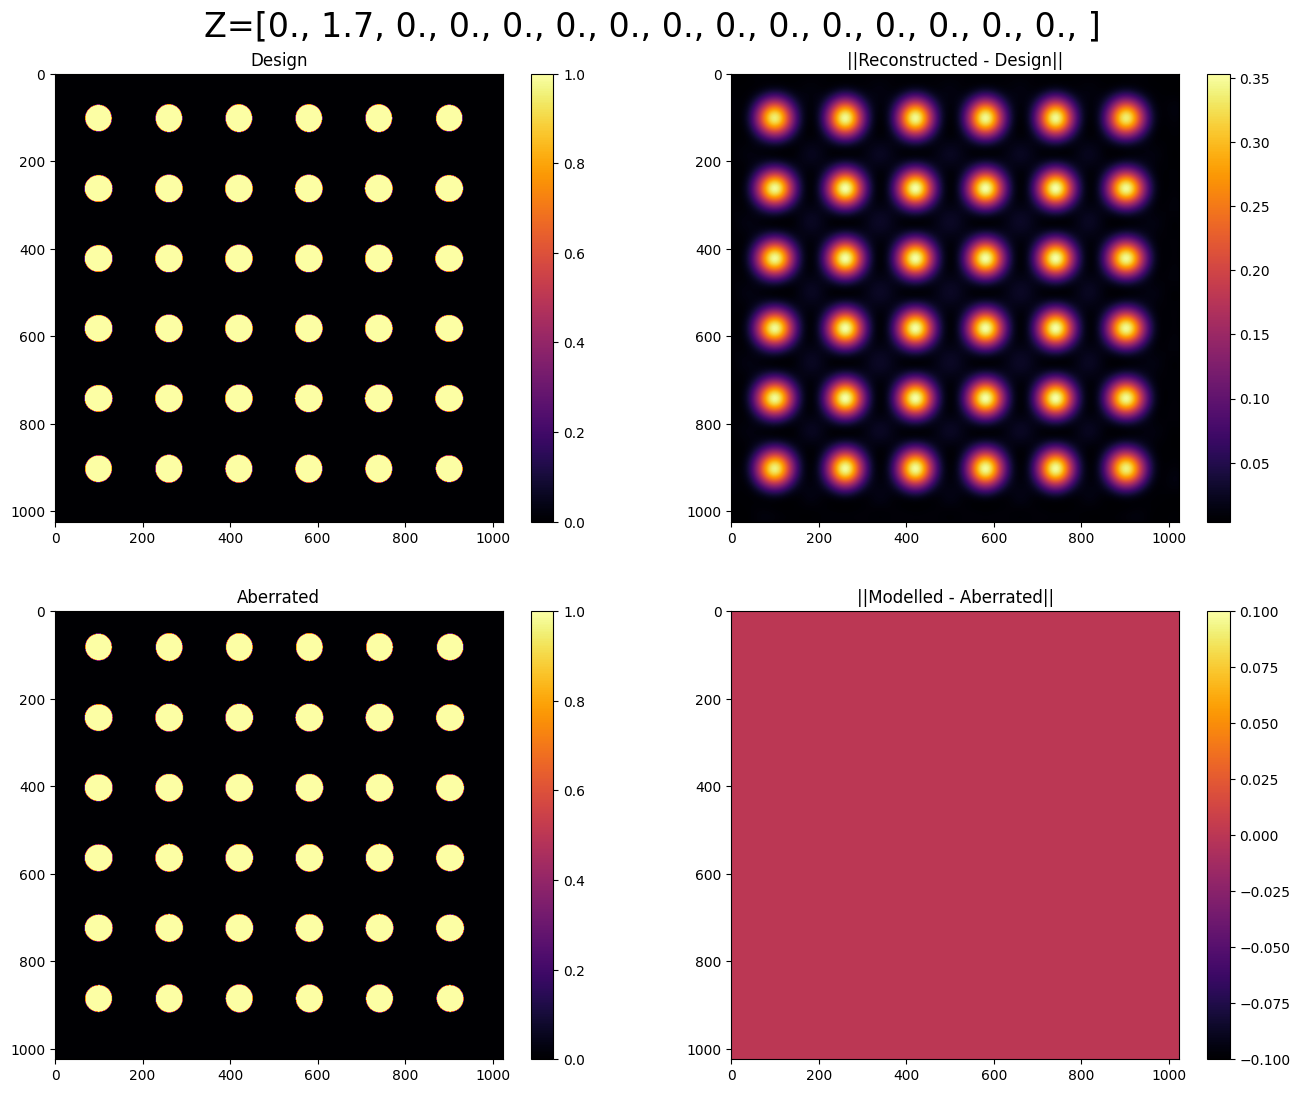

Aberrations: Z=[0.  0.  1.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ] Preds=[ 0.00819802 -0.16201705  1.2664444  -0.31840843  0.16091235 -0.13790596
 -0.07935802 -0.26875573 -0.18042779 -0.21726456 -0.01507809  0.0416818
  0.25280255  0.14941227  0.11336598] Inverse=[ 4.023167   -0.12030544 -0.4898212   2.013823    0.3655578  -0.7688248
  0.11722345 -0.01711474  0.15546624  0.04646856  0.1061662  -0.14875071
 -2.580268    1.669347   -2.841879  ]


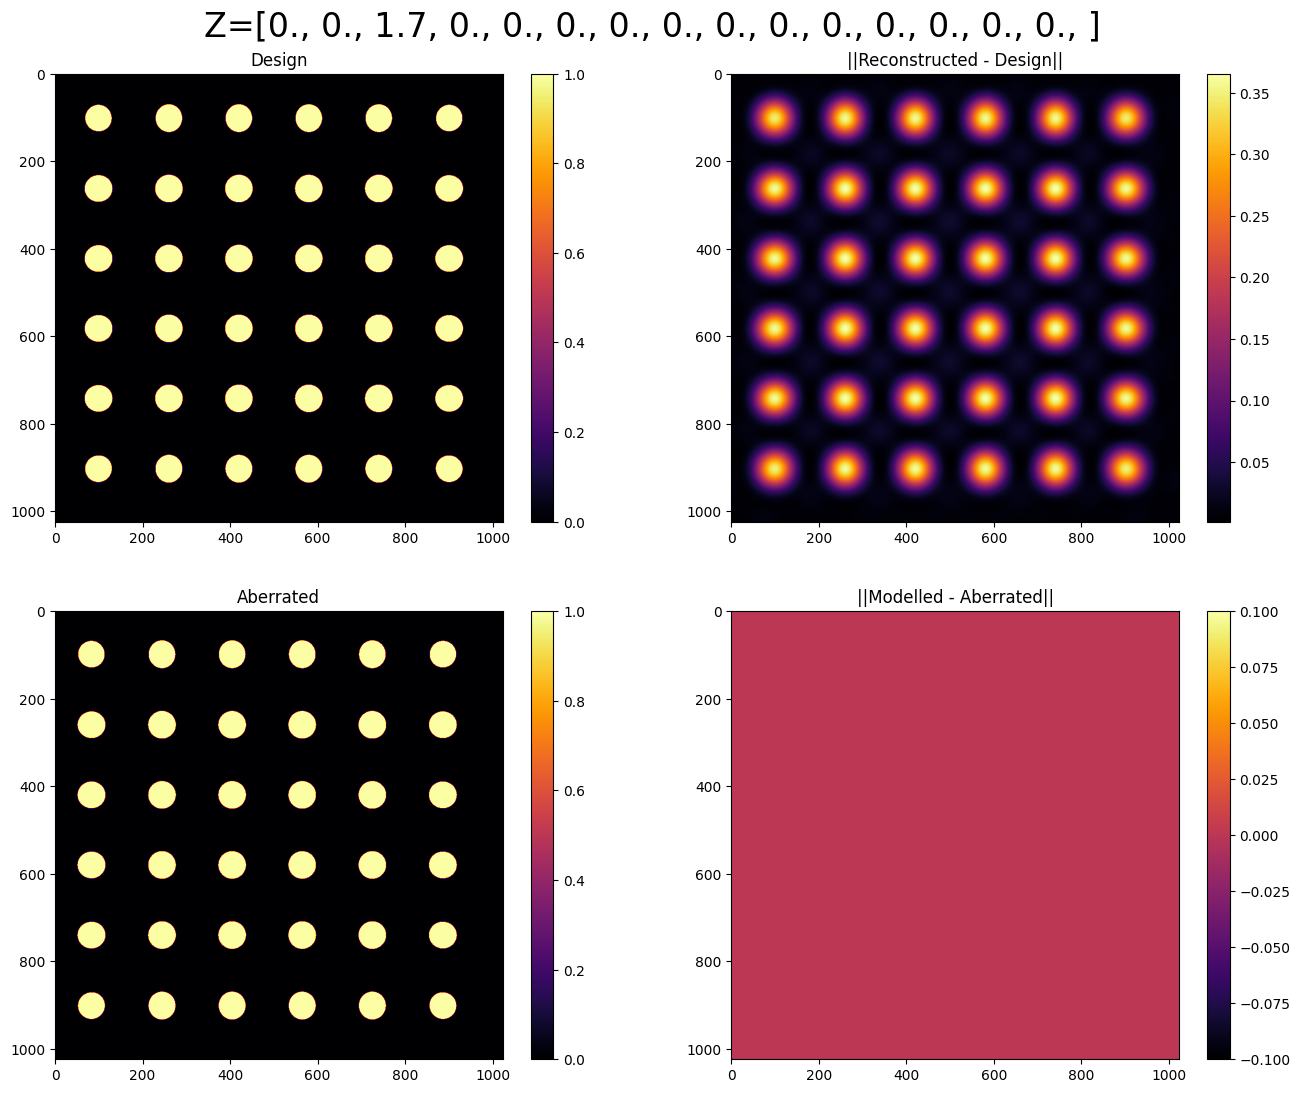

Aberrations: Z=[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Preds=[ 0.01230215 -0.21603307 -0.16819745 -0.00774184  0.297455   -0.20145047
 -0.10037235 -0.04050867 -0.0126455  -0.32259455  0.17298271  0.01777457
  0.06519315 -0.14048623  0.08691795] Inverse=[ 3.1231227   0.00914161  0.19051278  1.3317338   0.13652109 -0.66217595
  0.2008922   0.04836727 -0.3871542  -0.37977794  0.18748726 -0.5159563
 -1.7736382   1.9817708  -2.7877984 ]


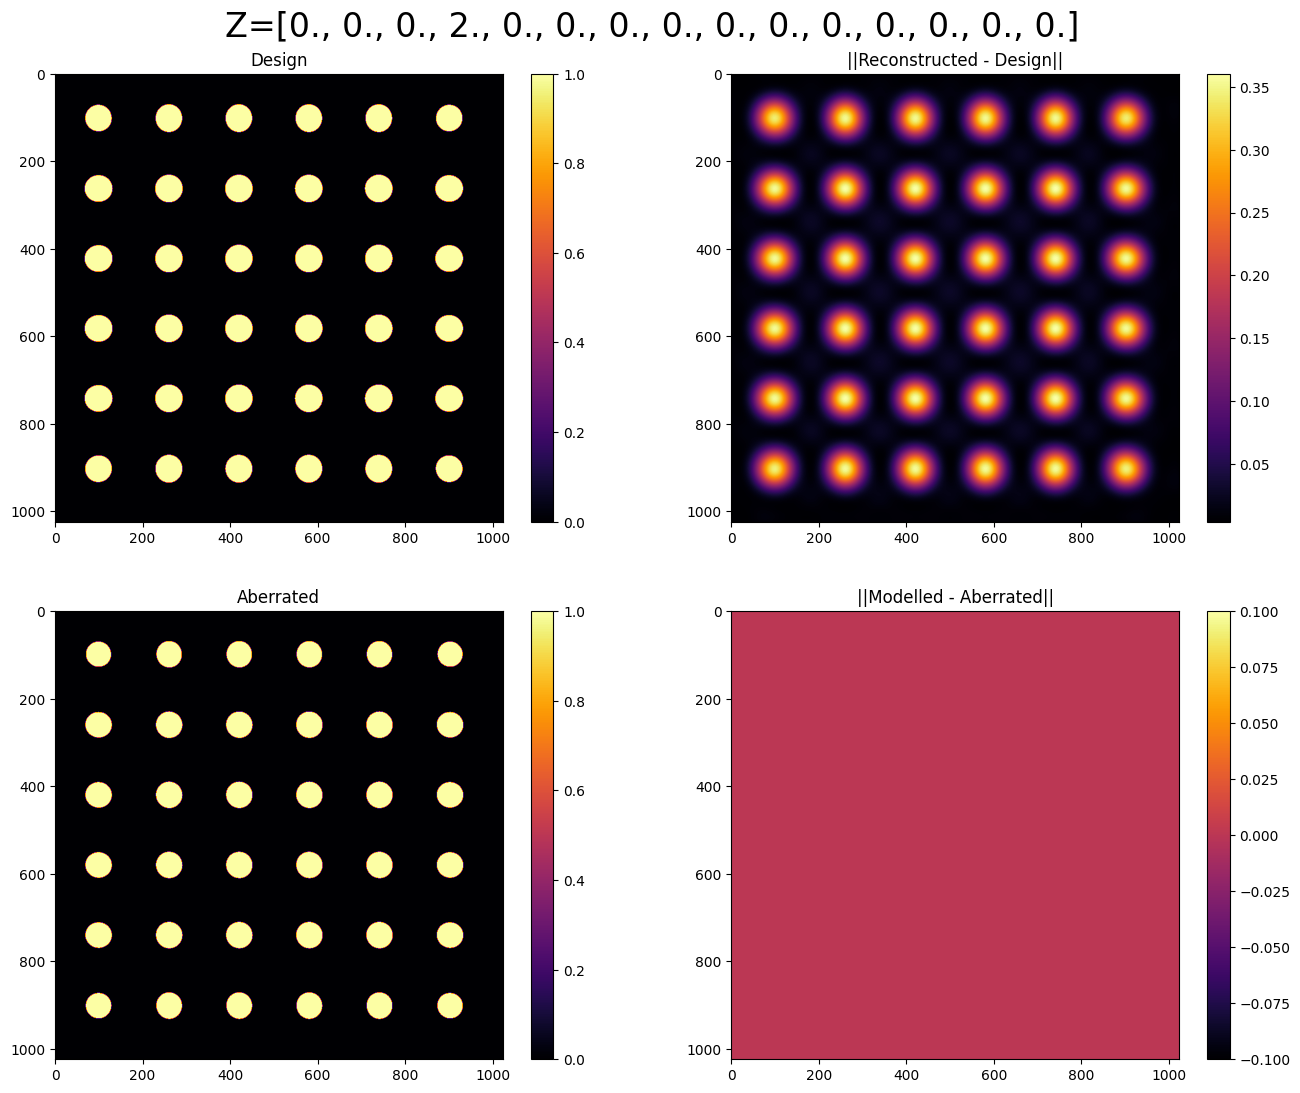

Aberrations: Z=[0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Preds=[-0.09617641 -0.6063962  -0.08646771 -0.644817    0.15601522  0.02104262
  0.02897843 -0.55061424 -0.3602282   0.86663264 -0.30847785 -0.09153412
 -0.22000727  0.8439537  -0.359932  ] Inverse=[ 1.3608522  -0.44803476 -0.22252199 -2.002684    0.05799496 -0.34409338
 -0.26078233  0.2875667   0.1400395   0.00364048 -0.6847213  -0.17652078
  1.7101187  -0.15697053  0.09153648]


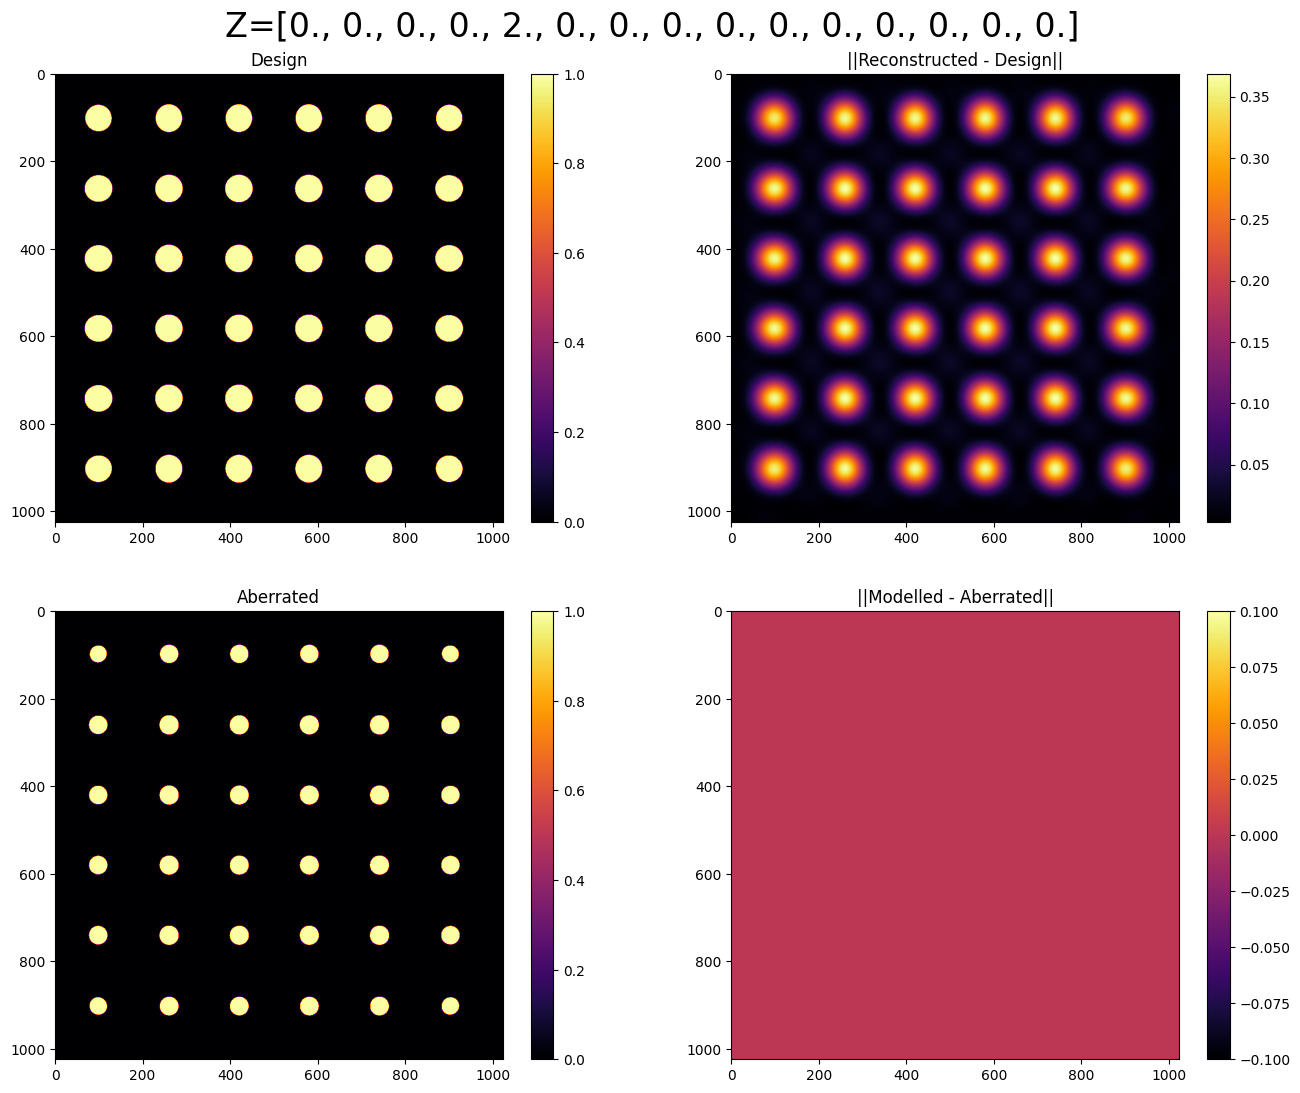

Aberrations: Z=[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.] Preds=[ 0.04640049 -1.730662    0.13988553  0.34786654  0.31100157 -0.4209282
 -0.5707734   0.8592384  -0.28870726 -0.5546281  -0.05121865  0.18466875
  0.02043231  0.07464253 -0.10862522] Inverse=[ 3.2192688   0.7989374  -0.03731713  1.6808841  -0.44012475 -0.9543993
  0.00943855 -0.82267493 -0.49713957 -0.09299437  0.44984874  0.03738478
 -2.2542424   0.8298955  -2.7196407 ]


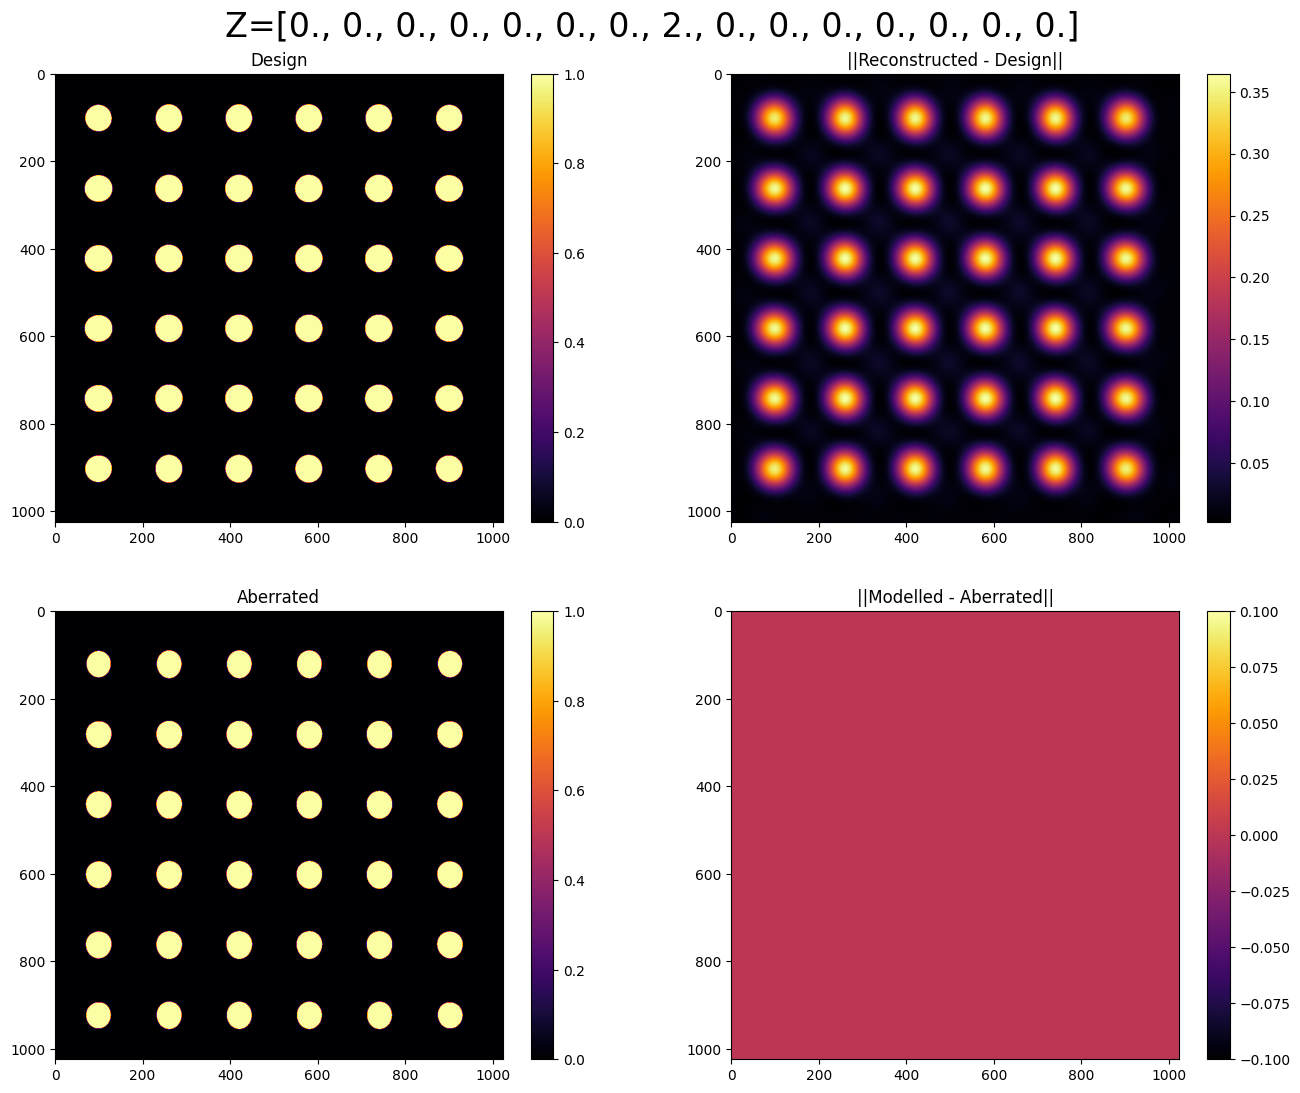

Aberrations: Z=[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.] Preds=[ 2.1757852e-02 -6.2547892e-01 -1.2599690e+00  1.9326454e-01
 -6.0237404e-02 -1.7195651e-01  2.8101200e-01 -7.8362525e-02
  2.0061986e-01  2.3110972e-01 -3.5992377e-02 -2.0277365e-01
  1.2688711e-04 -9.3924008e-02 -1.2425943e-01] Inverse=[ 3.9410162   0.57142234 -0.20473194  2.1001644  -0.00885592 -0.4847703
  0.44846016 -0.29140028 -0.4963103  -0.77697444  0.33441028  0.37707624
 -2.7156398   1.3165034  -2.3073454 ]


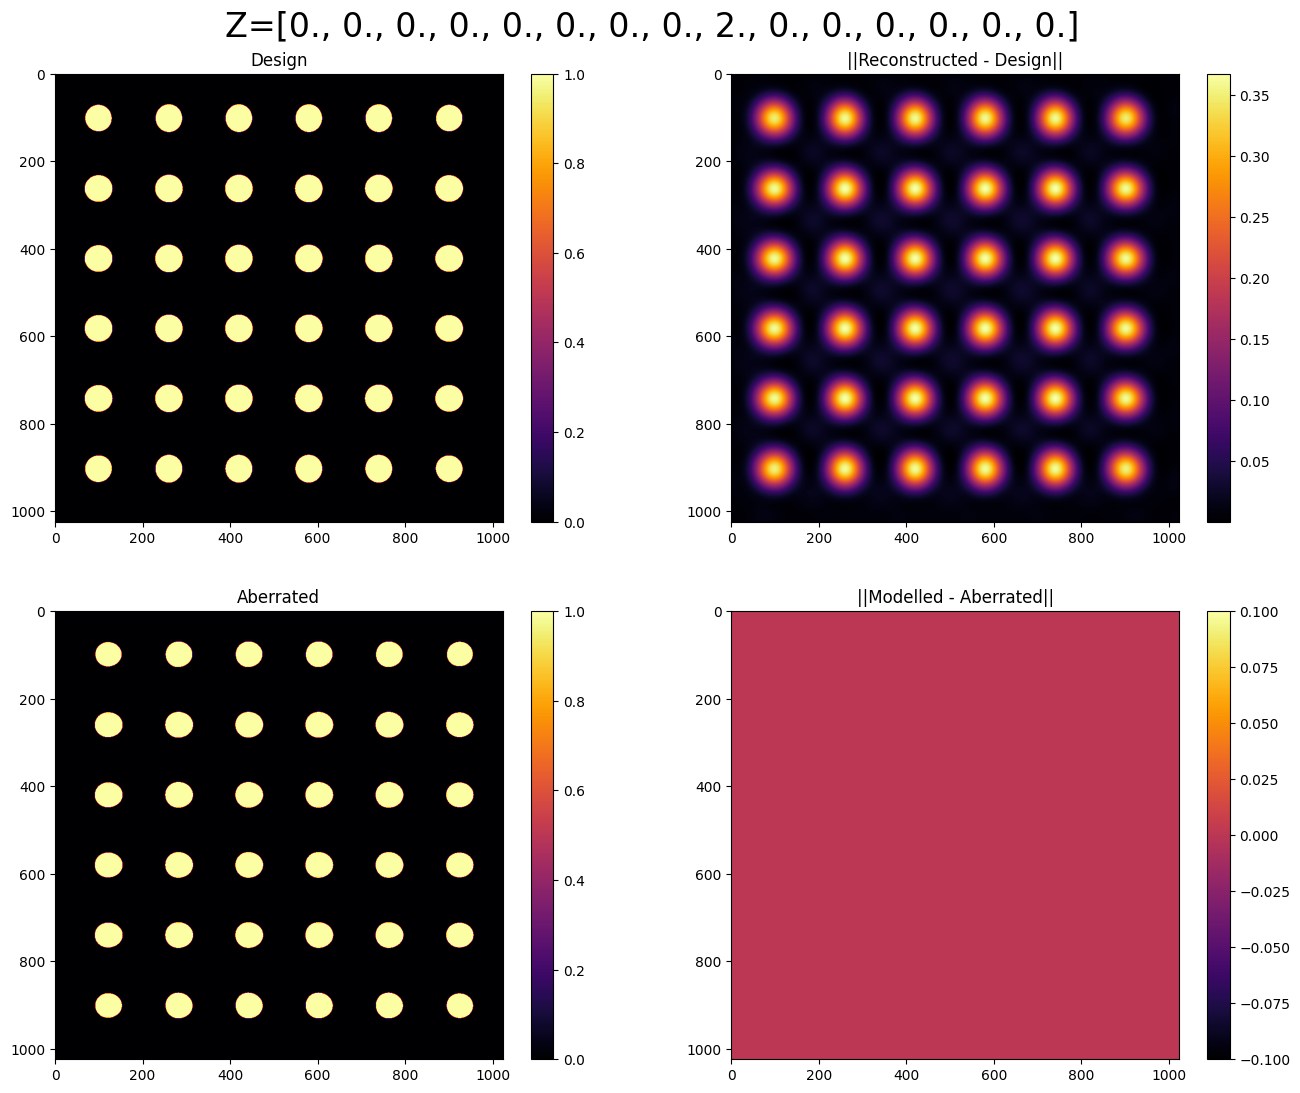

Aberrations: Z=[ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.] Preds=[ 0.02206812 -0.5400561   0.43146345  0.29014584  0.39151073 -0.36216912
 -0.18563949 -0.8314521  -0.07342845  1.5360954   1.0004618   0.01787207
 -0.07990862 -0.44173676  0.9024303 ] Inverse=[ 2.5551922  -0.23011142  0.20997573 -0.7181722   0.61303824  0.38405138
 -0.1140311   0.48653585  0.2577703   0.140323    0.24949925 -0.05980484
  0.96911705  1.9770195  -0.36653602]


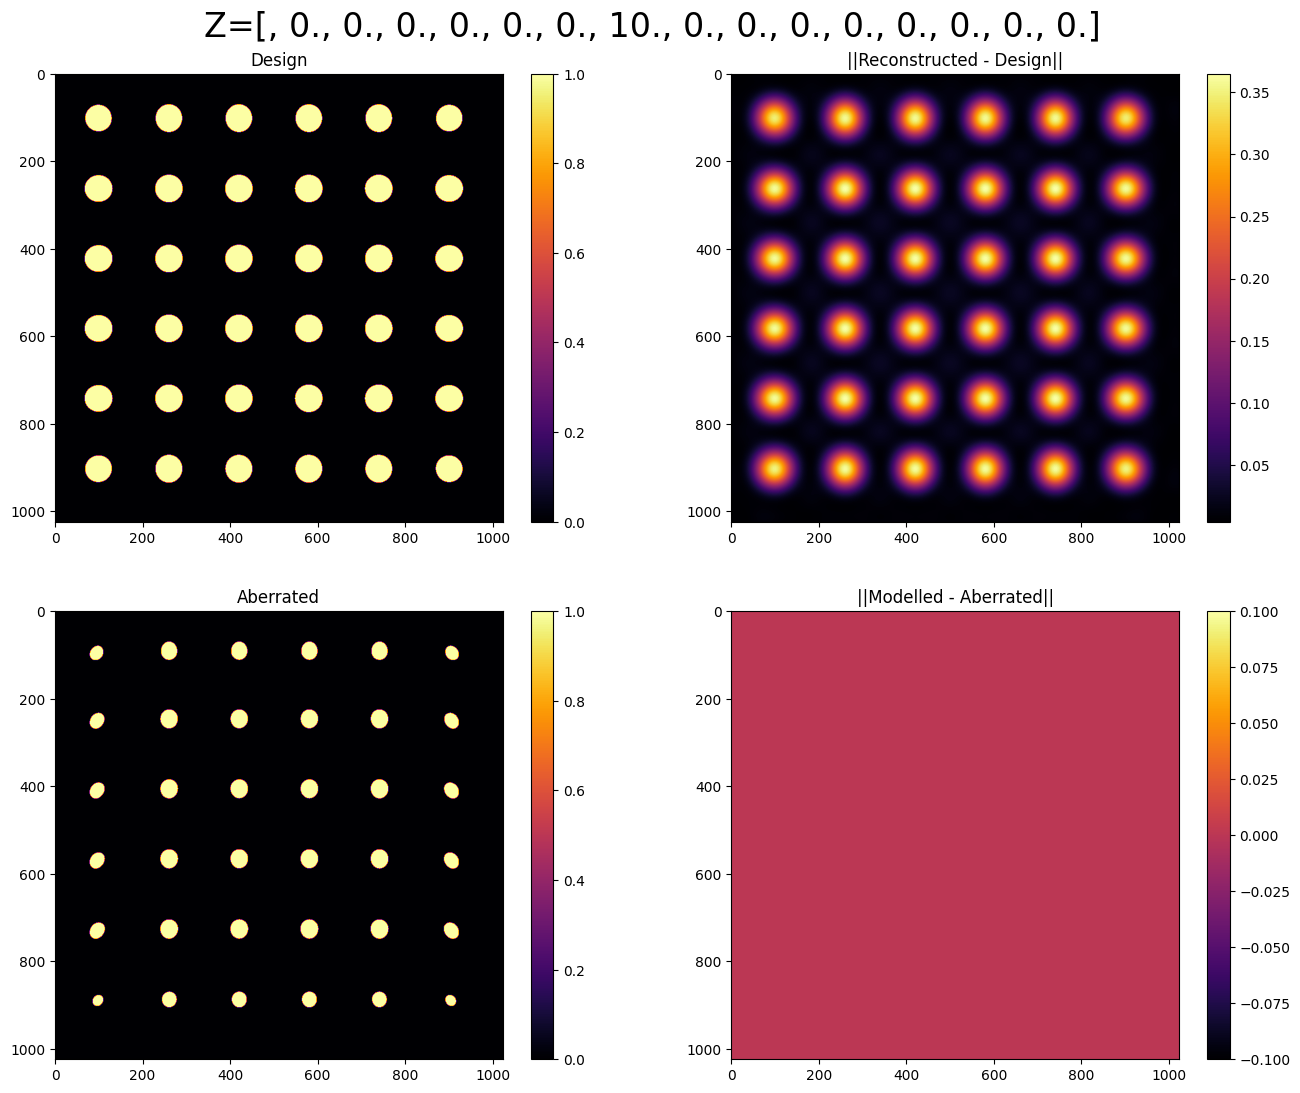

Aberrations: Z=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0.] Preds=[ 0.01715408 -0.37018716 -0.6748735  -0.15447007 -0.18176417  0.38127762
 -1.0452722   0.5239776  -0.5311276  -0.07126574  0.5733796   0.18855374
  0.23530181  0.22283505  0.18010981] Inverse=[ 9.1093057e-01  3.2900646e-01 -1.1981268e-01 -9.6348107e-01
  3.1892562e-01 -2.6799777e-01 -1.2980238e-01 -2.1415116e-01
  3.8717887e-01 -5.4015738e-01 -1.9112170e-01 -6.6130422e-04
  1.1620253e+00  2.7677366e-01  5.5897129e-01]


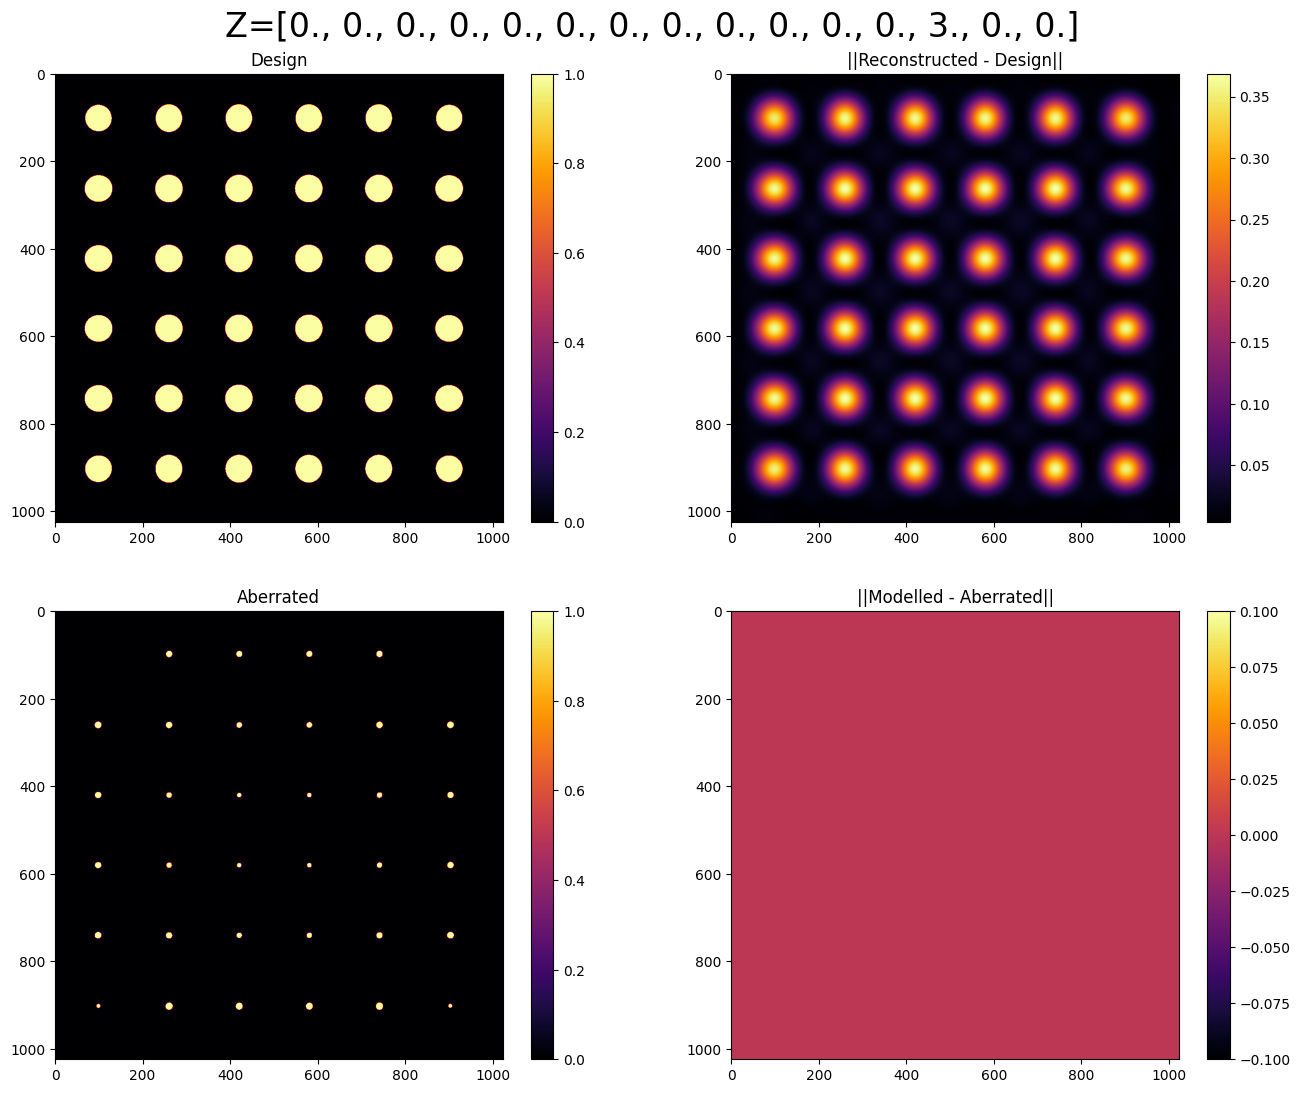

Aberrations: Z=[ 1.   0.9 -0.2  0.8  1.   0.9  0.   0.   0.   0.   0.   0.   0.   0.
  0. ] Preds=[-1.3075480e-03  1.3352622e+00 -4.7436881e-01 -9.3181908e-02
  2.1697238e-01  1.8059374e-01  1.1702908e+00  6.8542635e-01
  1.9706239e-01  2.0832509e-01 -3.9861530e-02  3.4695652e-01
  3.0981077e-02 -2.4134405e-01 -5.0149125e-01] Inverse=[ 1.687156   -0.09915165  0.3128908   0.51562166  0.18713354 -0.17132686
  0.33876446  0.21334974 -0.06734045 -0.6027935  -0.17218097  0.11134564
 -0.4331559  -0.08024246 -0.9636259 ]


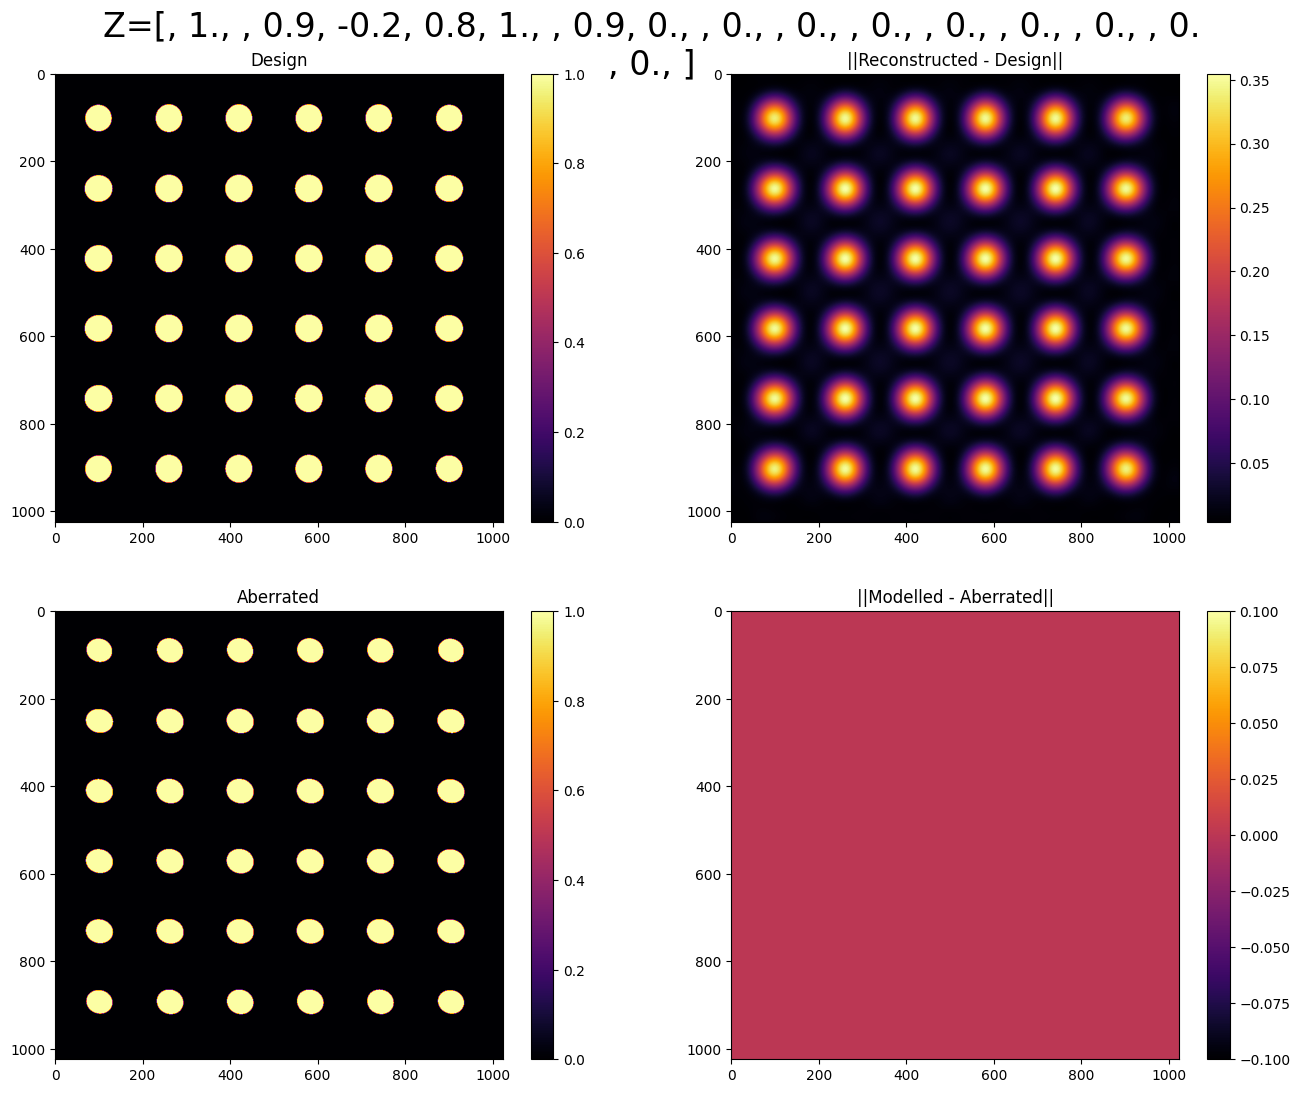

Aberrations: Z=[0.  0.7 0.7 2.  0.9 0.  0.  1.2 1.1 5.  0.  0.  0.  0.  0. ] Preds=[ 0.00448778 -0.10408905 -0.52310663 -0.25316054 -0.01179916 -0.11220834
  0.04550184  0.29751933 -0.56950307 -0.28240463 -0.16653562  0.17534064
  0.02378512 -0.00531439 -0.49517477] Inverse=[ 3.7525146   0.15458125 -0.17390142  3.2732506   0.138977   -0.39230305
  0.09034242 -0.10757112 -0.09344031 -0.19094174  0.31992447 -0.28753656
 -3.4384665   1.4300932  -3.0049448 ]


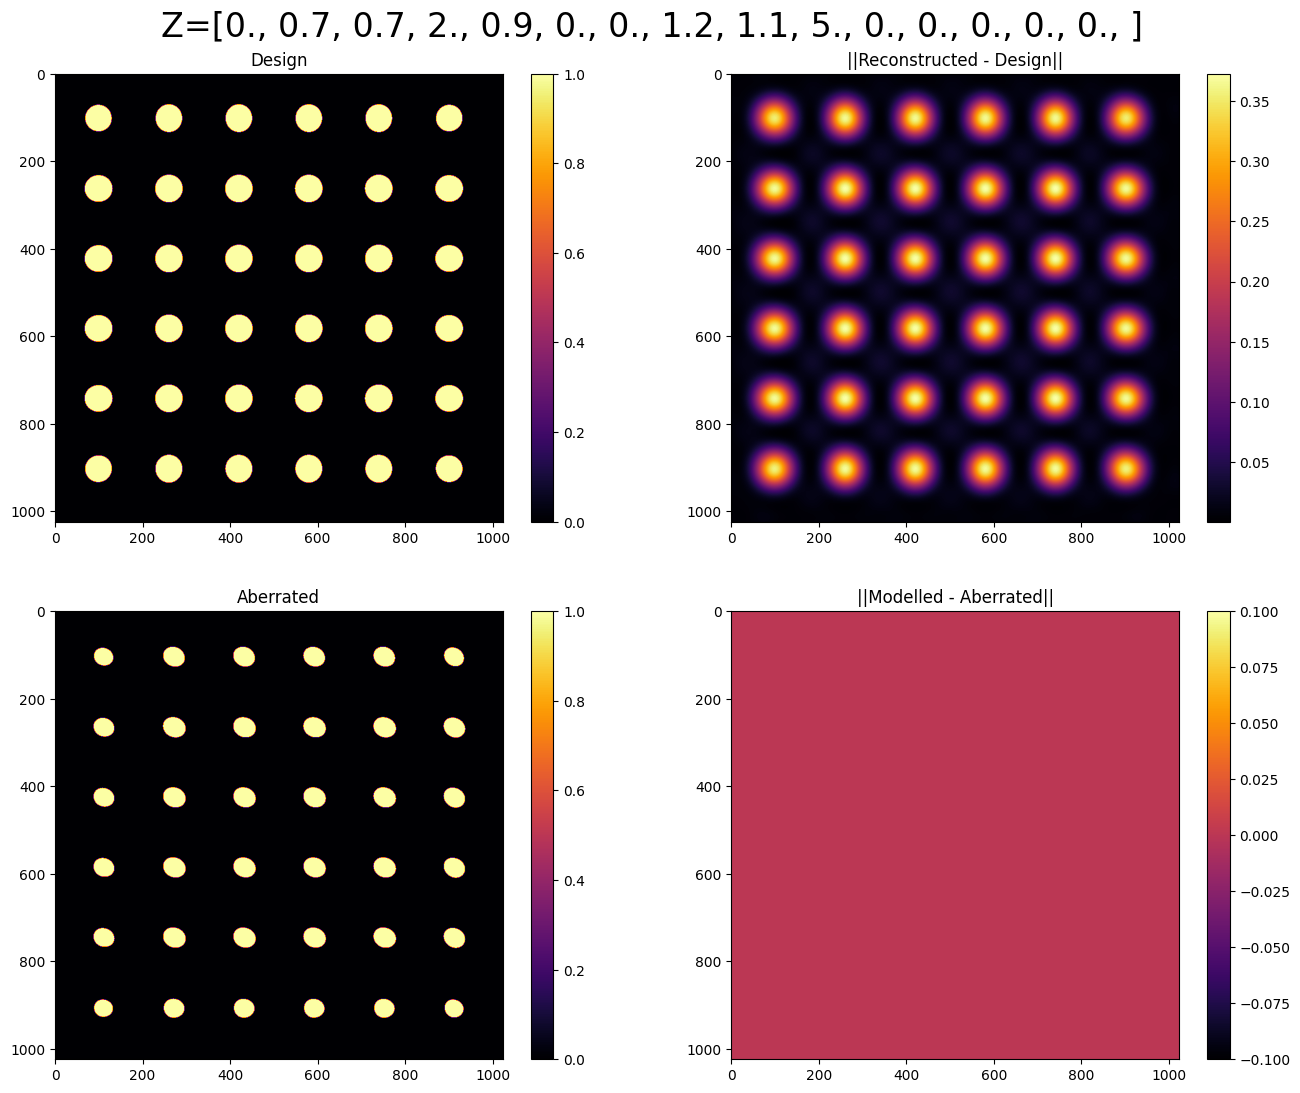

In [42]:
for i in range(imgs.shape[0]):
# dataset.intensity_tensor_to_image
    fig = plt.figure(figsize=(16,16*0.8))
    img = litho_imgs[i]
    z = z_true[i][i].item()
    alter_img = reconstructed_imgs[i]
    ax = plt.subplot(2,2,1)
    plt.imshow(dataset.intensity_tensor_to_image(img), cmap='inferno')
    ax.set_title(f"Design")
    plt.colorbar()

    ax = plt.subplot(2,2,2)
    plt.imshow(tensor_to_image(torch.abs(alter_img-img)), cmap='inferno')
    plt.colorbar()
    ax.set_title(f"||Reconstructed - Design||")

    ax = plt.subplot(2,2,3)
    img = aberr_imgs[i]
    alter_img = modelled_imgs[i]
    plt.imshow(dataset.intensity_tensor_to_image(img), cmap='inferno')
    ax.set_title(f"Aberrated")
    plt.colorbar()

    ax = plt.subplot(2,2,4)
    plt.imshow(dataset.intensity_tensor_to_image(torch.abs(alter_img-img)), cmap='inferno')
    ax.set_title(f"||Modelled - Aberrated||")
    plt.colorbar()

#     plt.suptitle(f"$Z[{i+1}]={z:.2f}$", fontsize=24, y=0.93)
    plt.suptitle(f"Z={str_canonize(z_true[i])}", fontsize=24, y=0.93)
    print(f"Aberrations: Z={z_true[i].cpu().numpy()}", 
          f"Preds={z_preds[i].detach().cpu().numpy()}", 
          f"Inverse={z_rev_preds[i].detach().cpu().numpy()}")
    plt.show()